## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import csv
import os.path
import json
from collections import defaultdict

import mplcyberpunk
plt.style.use("cyberpunk")

## 2. Uvoz podatkov

In [2]:
with open('../data/kd2018.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head0 = next(reader)
    none_handler = lambda i : i or None
    main_data18 = np.array([none_handler(i) for i in [row for row in reader]])

In [3]:
with open('../data/kd2019.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head1 = next(reader)
    none_handler = lambda i : i or None
    main_data19 = np.array([none_handler(i) for i in [row for row in reader]])

In [4]:
with open('../data/kd2020.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head2 = next(reader)
    none_handler = lambda i : i or None
    main_data20 = np.array([none_handler(i) for i in [row for row in reader]])

In [5]:
with open('../data/kd2021.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head3 = next(reader)
    none_handler = lambda i : i or None
    main_data21 = np.array([none_handler(i) for i in [row for row in reader]])

In [6]:
with open('../data/obcine_slovenije.csv', 'rt', encoding='utf8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    head_obcine = next(reader)
    none_handler = lambda i : i or None
    obcine = np.array([none_handler(i) for i in [row for row in reader]])

### 2.1 Priprava podatkov
V podatkih je nek zločin zapisan večrat. To je ocitno, saj se zaporedna številka kaznivega dejanja ponavlja večrat.

In [7]:
found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data18)):
    if (main_data18[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data18[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data18_filtered = main_data18[np.ma.make_mask(rows_to_keep)]

found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data19)):
    if (main_data19[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data19[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data19_filtered = main_data19[np.ma.make_mask(rows_to_keep)]

found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data20)):
    if (main_data20[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data20[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data20_filtered = main_data20[np.ma.make_mask(rows_to_keep)]

found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data21)):
    if (main_data21[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data21[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data21_filtered = main_data21[np.ma.make_mask(rows_to_keep)]

main_data = np.concatenate((main_data18_filtered, main_data19_filtered, main_data20_filtered, main_data21_filtered))

## 3.1 Izračun števila zločinov po dnevih

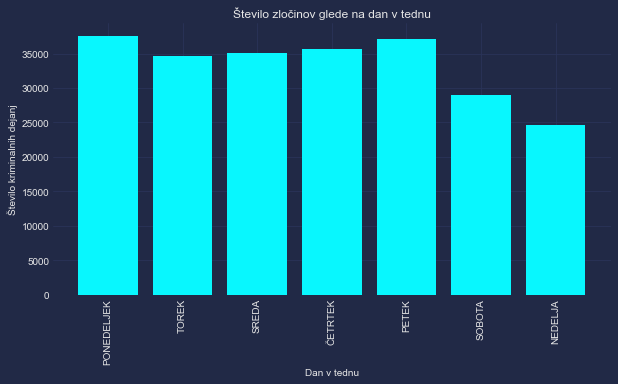

In [9]:
main_data_per_day = np.unique(main_data[:, 3], return_counts=True)
main_data_per_day = np.array(list(zip(main_data_per_day[0], main_data_per_day[1])))
main_data_per_day = np.array([main_data_per_day[2], main_data_per_day[5], main_data_per_day[4], main_data_per_day[6], main_data_per_day[1], main_data_per_day[3], main_data_per_day[0]])
main_data_per_day

plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
plt.title("Število zločinov glede na dan v tednu")
plt.xlabel('Dan v tednu')
plt.ylabel('Število kriminalnih dejanj')
plt.bar(main_data_per_day[:, 0], np.uint(main_data_per_day[:, 1]))
plt.show()

## 3.2. Uteževanje zločinov

In [10]:
# read json data from kazni_dict.json
with open('../data/kazni_dict.json', 'r', encoding='utf8') as f:
    kazni_dict = json.load(f)

In [11]:
kazni_utezi = dict()
for kd, values in kazni_dict.items():
        if (pd.isna(values['average_actual_jailtime'])):
            x = values['max_jailtime'] * 2 * values['dangerousness']
        else:
            x = (values['max_jailtime'] + values['average_actual_jailtime']) * values['dangerousness']
        kazni_utezi[kd] = x

In [12]:
dnevi = dict.fromkeys(["ponedeljek", "torek", "sreda", "četrtek", "petek", "sobota", "nedelja"], 0)
kd_errors_dict = defaultdict(int)


for kd in main_data:
    dan = str.lower(kd[3])
    kd = str.lower(str.strip(str.split(kd[6], '-')[-1]))
    if (kd == 'poneverba in neupravičena uporaba tujega premoženja' or kd == ''):
        continue
    try:
        dnevi[dan] += kazni_utezi[kd]
    except KeyError:
            kd_errors_dict[kd] += 1
            print(f"NAPAKA PRI \"{kd}\"")

# kd_errors = np.array(list(kd_errors_dict.items()), dtype=object)
# kd_errors = kd_errors[np.argsort(kd_errors[:, 1])[::-1]]
# kd_errors

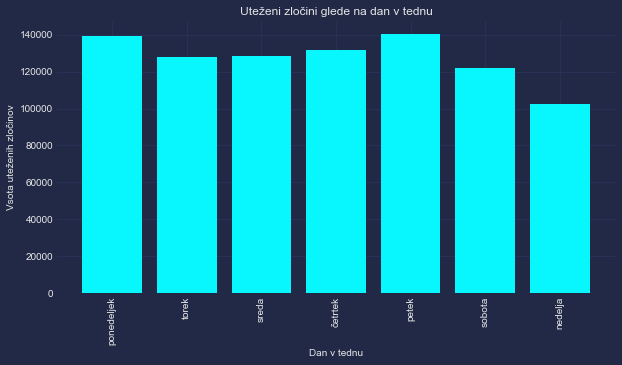

In [14]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
plt.title("Uteženi zločini glede na dan v tednu")
plt.xlabel('Dan v tednu')
plt.ylabel('Vsota uteženih zločinov')
plt.bar(dnevi.keys(), dnevi.values())
plt.show()

## 3.3. Za vsako občino posebaj

In [16]:
obc_dnevi = dict.fromkeys([str.lower(x) for x in np.unique(obcine[:, 0])], dict.fromkeys(["ponedeljek", "torek", "sreda", "četrtek", "petek", "sobota", "nedelja"], 0))
kd_errors_dict = defaultdict(int)


for kd in main_data:
    dan = str.lower(kd[3])
    obcina = str.lower(kd[19])
    kd = str.lower(str.strip(str.split(kd[6], '-')[-1]))
    if (obcina == 'neznana ue' or obcina == 'neznana obč' or obcina == 'ni podatka' or kd == 'poneverba in neupravičena uporaba tujega premoženja' or kd == ''):
        continue
    if (obcina == 'šentjur pri celju'):
        obcina = 'šentjur'
    try:
        obc_dnevi[obcina][dan] += kazni_utezi[kd]
    except KeyError:
            kd_errors_dict[kd] += 1
            print(f"NAPAKA PRI \"{kd}\"")

# kd_errors = np.array(list(kd_errors_dict.items()), dtype=object)
# kd_errors = kd_errors[np.argsort(kd_errors[:, 1])[::-1]]
# kd_errors

In [25]:
# write obc_dnevi to json file
with open('../data/obc_dnevi.json', 'w') as f:
    json.dump(obc_dnevi, f)